## load package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:

In [2]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

## load data

In [3]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/P22mousebrain_data/"
RNA_data = pd.read_csv(data_path+'feature_selected_RNA.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'feature_selected_ATAC.txt', sep='\t', index_col=0)

In [4]:
spatial = pd.read_csv(data_path + "Spots.coords.tsv.gz",sep='\t', index_col=0, header=None)
spatial = np.array(spatial)

In [5]:
RNA_cluster = pd.read_csv(data_path +'P22_putative_clusters.txt', sep='\t')
RNA_cluster = RNA_cluster.reset_index()
RNA_cluster = RNA_cluster.rename(columns={'index':'cell','x': 'cluster'})
ATAC_cluster = RNA_cluster.copy()

In [6]:
X1 = ATAC_data.T
X2 = RNA_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.columns)
cell_names2 = list(RNA_data.columns)
peak_names = list(ATAC_data.index)
gene_names = list(RNA_data.index)

Dimensions of input datasets are:  X1 =  (9215, 5061)  X2 =  (9215, 503)
Dimensions of basic_labels are:  basic_labels1 =  (9215,)  basic_labels2 =  (9215,)


## build a priori feature graph

In [7]:
promoters = pd.read_csv(data_path+'mm10_TSS.txt', sep = '\t')
promoters = promoters.rename(columns={'start': 'starts','end': 'ends','Gene': 'genes'})
promoters.head()

,chr,starts,ends,genes
1,chr1,3466587,3513553,Gm1992
2,chr1,3205901,3671498,Xkr4
3,chr1,3905739,3986215,Gm37381
4,chr1,4292981,4409187,Rp1_2
5,chr1,3999557,4409241,Rp1


In [8]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names, scope=150000)
feature_matrix

27916it [00:00, 500460.29it/s]
27916it [00:00, 37002.44it/s]
100%|██████████| 503/503 [00:00<00:00, 1434.37it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 496 5061 5340


100%|██████████| 5340/5340 [00:00<00:00, 1467827.73it/s]


,Sulf1,Rims1,Smap1,Ercc5,Wdr75,Spats2l,Gm973,Wdr12,Pard3b,Dock10,...,Rpgr,Enox2,Pls3,Pola1,Plp1,Cnksr2,Map7d2,Sh3kbp1,Arhgap6,Eif2s3y
chr13-97918017-97918907,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-24300824-24301679,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr3-14917009-14917924,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr11-107762826-107763736,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr8-84722792-84723543,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr13-55329475-55330407,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr18-61505089-61505954,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr8-14906700-14907639,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr11-98909339-98910246,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

We use wnn to calculate cost for paired data.

In [2]:
import anndata
file_path = "/home/nas2/biod/yangchenghui/my_ych_project_P22brain_new/P22_in_spatialGLUE/"

In [ ]:
adata_tmp = anndata.read_h5ad(file_path + "P22_SpatialGLUE_adata.h5ad")
adata_tmp

In [11]:
smi = adata_tmp.obsp['connectivities'].toarray()
np.fill_diagonal(smi, 1)

In [13]:
cost = np.array(np.exp(1 - smi))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

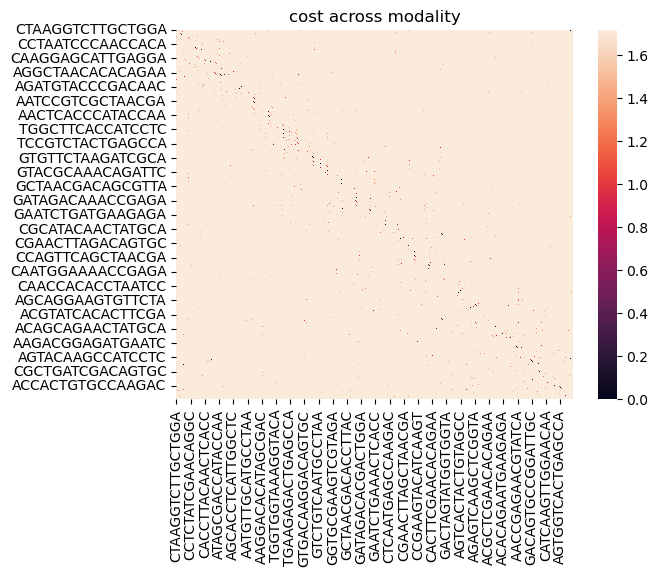

In [14]:
sns.heatmap(cost)
pl.title('cost across modality')

## scale

In [9]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [16]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=600, pair = True, device='cuda:6', eps_p = 5e-2)

import pickle
with open('/home/nas2/biod/yangchenghui/my_ych_project_P22brain_new/P22_in_spatialGLUE/P_tensor_P22_SpatialGlue.pickle', 'wb') as file:
    pickle.dump(P_tensor, file)

minibatch = 1 and device =  cuda:6
the total number of computing batch is  15


100%|██████████| 15/15 [16:57<00:00, 67.85s/it]


In [10]:
import pickle

# 从pickle文件读取数据
with open('/home/nas2/biod/yangchenghui/my_ych_project_P22brain_new/P22_in_spatialGLUE/P_tensor_P22_SpatialGlue.pickle', 'rb') as file:
    P_tensor = pickle.load(file)

## make multi-omics alignment from the transport tensor

In [18]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 5340/5340 [18:15<00:00,  4.88it/s]


(9215, 9215)

Text(0.5, 1.0, 'optimal transport matrix')

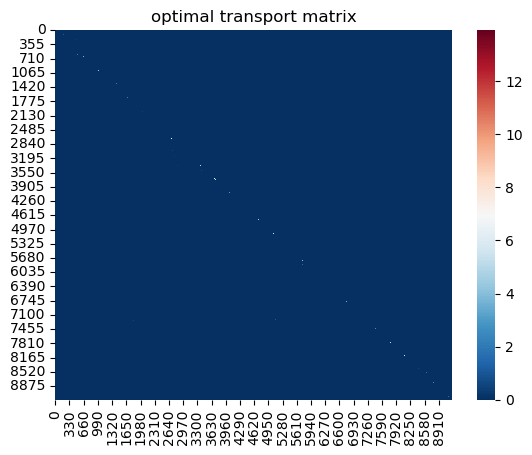

In [19]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [107]:
X1_aligned, X2_aligned = align(X1, X2, P, mode="RNA2ATAC")

In [128]:
data_aligned = np.concatenate((X1_aligned, X2_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['ATAC'] * n1 + ['RNA'] * n2)
adata_aligned.obsm['spatial'] = np.concatenate((spatial,spatial), axis=0)

#sc.tl.pca(adata_aligned)
import sklearn.utils.extmath
X_lsi = sklearn.utils.extmath.randomized_svd(adata_aligned.X, n_components = 30)[0]
X_lsi -= X_lsi.mean(axis=1, keepdims=True)
X_lsi /= X_lsi.std(axis=1, ddof=1, keepdims=True)
adata_aligned.obsm["X_lsi"] = X_lsi

sc.pp.neighbors(adata_aligned, n_neighbors=15, use_rep = "X_lsi", metric = "cosine")
sc.tl.umap(adata_aligned)

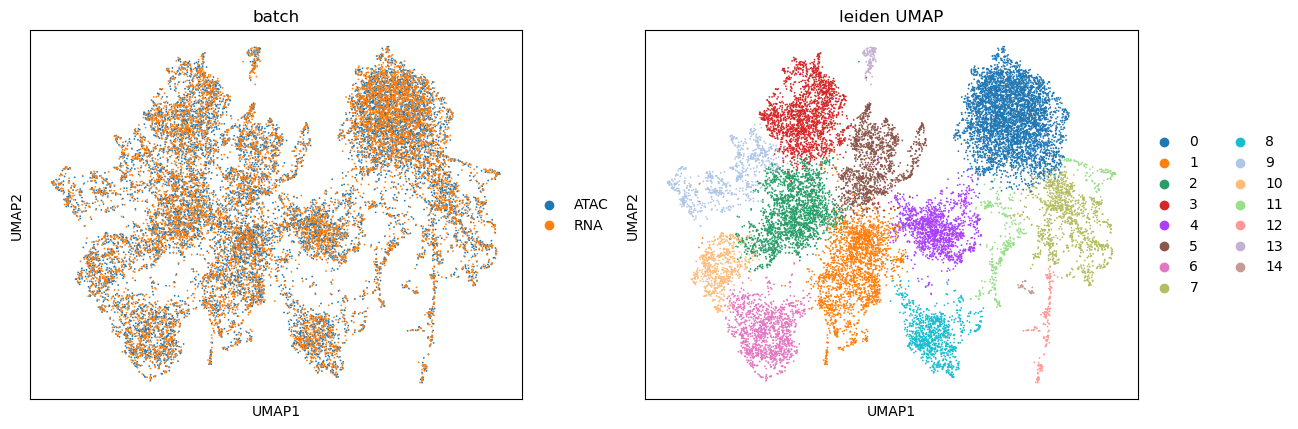

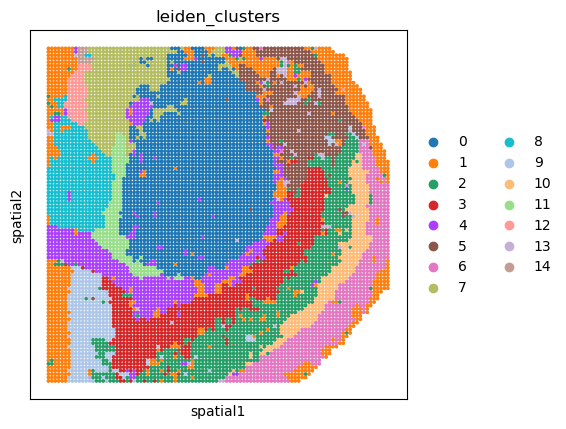

In [134]:
sc.tl.leiden(adata_aligned, key_added='leiden_clusters',resolution=0.4)
sc.pl.umap(adata_aligned, color = ['batch','leiden_clusters'], title=['batch','leiden UMAP'],show = False)
sc.pl.spatial(adata_aligned, img_key=None, color="leiden_clusters",spot_size = 1)

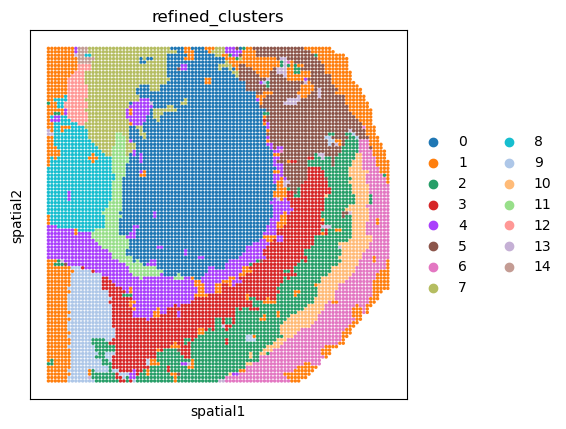

In [135]:
# Draw spatial fig only for RNA
adata_aligned_rna = adata_aligned[adata_aligned.obs["batch"] == "RNA"]
distance_matrix = FGOT.utils.get_distance_matrix(spatial)
adata_aligned_rna.obs['refined_clusters'] = FGOT.fgot.refine(cell_names2,list(adata_aligned_rna.obs['leiden_clusters']), distance_matrix, shape="square")
sc.pl.spatial(adata_aligned_rna, img_key=None, color=["refined_clusters"],spot_size = 1)

In [138]:
adata_aligned.write_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_P22brain_new/P22_in_spatialGLUE/P22_FGOT_SpatialGlue_adata.h5ad")

In [1]:
import anndata as ad
adata_aligned = ad.read("/home/nas2/biod/yangchenghui/my_ych_project_P22brain_new/P22_in_spatialGLUE/P22_FGOT_SpatialGlue_adata.h5ad")
adata_aligned

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 18430 × 5061
    obs: 'batch', 'leiden_clusters'
    uns: 'batch_colors', 'leiden_clusters', 'leiden_clusters_colors', 'neighbors', 'umap'
    obsm: 'X_lsi', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

/tmp/ipykernel_1603708/2289430618.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_aligned_rna.obs['refined_clusters'] = FGOT.fgot.refine(cell_names2,list(adata_aligned_rna.obs['leiden_clusters']), distance_matrix, shape="square")


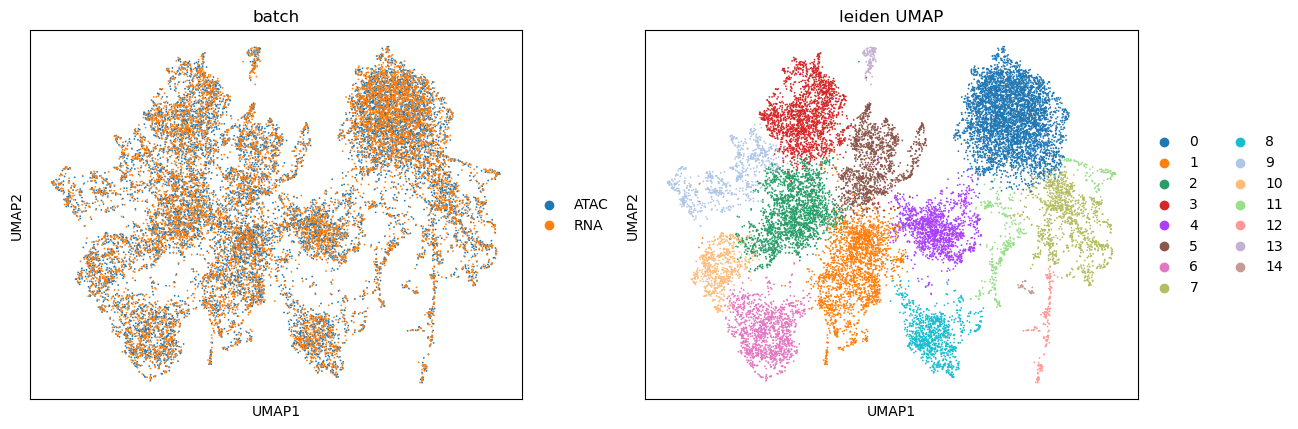

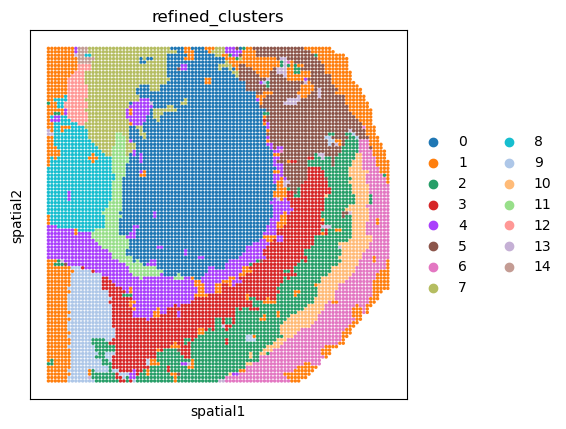

In [15]:
sc.pl.umap(adata_aligned, color = ['batch','leiden_clusters'], title=['batch','leiden UMAP'],show = False)
pl.savefig("/home/nas2/biod/yangchenghui/my_ych_project_P22brain_new/P22_in_spatialGLUE/P22_FGOT_SpatialGLUE_embedding.pdf")

# Draw spatial fig only for RNA
adata_aligned_rna = adata_aligned[adata_aligned.obs["batch"] == "RNA"]
distance_matrix = FGOT.utils.get_distance_matrix(spatial)
adata_aligned_rna.obs['refined_clusters'] = FGOT.fgot.refine(cell_names2,list(adata_aligned_rna.obs['leiden_clusters']), distance_matrix, shape="square")
sc.pl.spatial(adata_aligned_rna, img_key=None, color=["refined_clusters"],spot_size = 1,show = False)
pl.savefig("/home/nas2/biod/yangchenghui/my_ych_project_P22brain_new/P22_in_spatialGLUE/P22_FGOT_SpatialGLUE_embedding_spatial.pdf")

## infer the cell type specific regulatory intensity from the transport tensor

In [11]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'RNA2ATAC')
intensity_df

100%|██████████| 5061/5061 [2:21:47<00:00,  1.68s/it]  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
chr13-97918017-97918907-Arhgef28,1.618171e-07,6.880956e-07,1.674961e-06,1.178288e-06,1.941015e-06,1.467086e-06,1.076193e-06,2.851006e-06,3.951690e-06,4.947447e-06,1.714557e-06,7.243755e-06,2.072703e-06,3.532903e-07,3.373402e-06,0.000009,0.000005
chr19-24300824-24301679-Pip5k1b,2.791311e-07,3.857890e-07,5.041936e-07,5.867396e-07,1.144729e-06,1.284904e-06,8.760196e-07,2.051501e-06,8.848136e-07,1.711789e-06,1.079413e-06,3.108860e-06,2.099579e-06,2.460061e-06,4.114555e-06,0.000004,0.000007
chr3-14917009-14917924-Car2,2.107205e-06,3.073166e-07,6.607451e-07,1.523085e-06,5.251635e-06,3.847167e-06,2.683593e-07,2.126497e-06,1.084548e-07,6.300855e-07,1.514987e-06,1.463190e-06,6.694738e-06,2.484374e-05,3.970791e-05,0.000051,0.000000
chr11-107762826-107763736-Cacng4,1.211653e-06,2.383772e-07,3.438822e-07,8.886116e-07,1.228940e-06,2.808848e-06,1.153124e-07,2.174577e-06,1.010180e-06,8.322858e-07,9.397512e-07,1.017738e-06,1.481171e-05,1.741789e-05,2.461276e-05,0.000031,0.000005
chr8-84722792-84723543-Nfix,5.399792e-08,5.853031e-07,1.129727e-06,6.941966e-07,7.201131e-07,1.244328e-07,1.702448e-06,2.989839e-07,1.440689e-06,2.868674e-06,2.903367e-06,6.523238e-07,8.325490e-06,2.428291e-07,1.604849e-07,0.000001,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr13-55329475-55330407-Grk6,4.591832e-07,9.906438e-07,1.420131e-06,5.774999e-07,1.354421e-06,1.613160e-06,1.393231e-06,1.095088e-06,2.091465e-06,4.892486e-06,2.777894e-06,2.841227e-06,1.380133e-05,3.761401e-06,1.778131e-06,0.000064,0.000002
chr18-61505089-61505954-Mir143hg,2.545511e-07,2.243085e-07,2.022726e-07,6.415790e-07,2.713444e-07,5.807947e-07,2.753555e-07,5.369610e-07,4.898001e-07,5.672902e-07,9.135135e-07,1.172520e-06,8.343330e-07,2.253970e-06,2.149002e-06,0.000011,0.000012
chr8-14906700-14907639-Arhgef10,5.195097e-07,4.545382e-07,7.872870e-07,5.556626e-07,7.362780e-06,1.005787e-06,4.163316e-07,1.617314e-06,1.029380e-06,9.358130e-07,5.444124e-07,1.372395e-06,7.836689e-06,5.672569e-06,8.789017e-06,0.000013,0.000005
chr11-98909339-98910246-Top2a,1.960566e-07,2.068340e-07,4.678108e-07,1.877576e-07,5.690297e-07,1.136914e-06,5.013642e-07,7.539297e-07,5.137136e-07,1.611092e-06,8.836778e-07,7.978963e-07,1.752878e-05,1.412284e-06,5.336175e-06,0.000002,0.000017


In [12]:
intensity_df.to_csv('/home/nas2/biod/yangchenghui/my_ych_project_P22brain_new/P22_in_spatialGLUE/P22_FGOT_SpatialGLUE_regulation.txt') 